In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib
from scipy.spatial import Delaunay
from matplotlib.collections import PatchCollection
from scipy.spatial import ConvexHull 
import math
import pyvista as pv
import statistics
%matplotlib widget

In [2]:
par_data = np.genfromtxt("par_data.csv", delimiter=',', skip_header = 34, comments = 'TIME')
par_data = np.delete(par_data, 0, axis = 1)
n_par = np.shape(par_data)[1]

In [3]:
min_dia_tr = 0.0015
n_par_tot = np.shape(par_data)[1]
mem_par_indexes = []
for i in range(n_par_tot):
    if par_data[4][i] < min_dia_tr:
        mem_par_indexes.append(i)

par_data = np.delete(par_data, mem_par_indexes, 1)

In [4]:
par_init = np.transpose(par_data[0:5]) 
par_mid = np.transpose(par_data[5:10])
par_fin = np.transpose(par_data[10:15])

In [5]:
p_init = par_init[:,1:4]
p_mid = par_mid[:,1:4]
p_fin = par_fin[:,1:4]
tri = Delaunay(p_init)
arr_max = 2
tetras = tri.vertices
tetras_new = []
for tetra in tqdm(tetras, desc = "current arr_amx = %f"%arr_max):
    points_init = np.array([p_init[tetra[0]], p_init[tetra[1]], p_init[tetra[2]], p_init[tetra[3]]])
    dis_ar = (math.dist(p_init[tetra[0]], p_init[tetra[1]]),
              math.dist(p_init[tetra[1]], p_init[tetra[2]]),
              math.dist(p_init[tetra[2]], p_init[tetra[3]]),
              math.dist(p_init[tetra[3]], p_init[tetra[0]]),
              math.dist(p_init[tetra[3]], p_init[tetra[1]]),
              math.dist(p_init[tetra[0]], p_init[tetra[2]]))
    max_dist = max(dis_ar)
    min_dist = min(dis_ar)
    ar = max_dist/min_dist
    if ar < arr_max:
        tetras_new.append(tetra)

current arr_amx = 2.000000: 100%|█████████████████████████| 22981/22981 [00:00<00:00, 26194.84it/s]


In [6]:
i = 0        
small_strain_tensors_mid = np.zeros([np.shape(tetras_new)[0], 6])
green_strain_tensors_mid = np.zeros([np.shape(tetras_new)[0], 6])
small_strain_tensors_fin = np.zeros([np.shape(tetras_new)[0], 6])
green_strain_tensors_fin = np.zeros([np.shape(tetras_new)[0], 6])
for tetra in tetras_new:
    C = np.array([[1, p_init[tetra[0]][0], p_init[tetra[0]][1], p_init[tetra[0]][2]],
                      [1, p_init[tetra[1]][0], p_init[tetra[1]][1], p_init[tetra[1]][2]],
                      [1, p_init[tetra[2]][0], p_init[tetra[2]][1], p_init[tetra[2]][2]],
                      [1, p_init[tetra[3]][0], p_init[tetra[3]][1], p_init[tetra[3]][2]]])
    del_x_1 = p_mid[tetra[0]][0] - p_init[tetra[0]][0] 
    del_x_2 = p_mid[tetra[1]][0] - p_init[tetra[1]][0]
    del_x_3 = p_mid[tetra[2]][0] - p_init[tetra[2]][0]
    del_x_4 = p_mid[tetra[3]][0] - p_init[tetra[3]][0]
    del_y_1 = p_mid[tetra[0]][1] - p_init[tetra[0]][1]
    del_y_2 = p_mid[tetra[1]][1] - p_init[tetra[1]][1]
    del_y_3 = p_mid[tetra[2]][1] - p_init[tetra[2]][1]
    del_y_4 = p_mid[tetra[3]][1] - p_init[tetra[3]][1]
    del_z_1 = p_mid[tetra[0]][2] - p_init[tetra[0]][2]
    del_z_2 = p_mid[tetra[1]][2] - p_init[tetra[1]][2]
    del_z_3 = p_mid[tetra[2]][2] - p_init[tetra[2]][2]
    del_z_4 = p_mid[tetra[3]][2] - p_init[tetra[3]][2]
    Dx = [del_x_1, del_x_2, del_x_3, del_x_4]
    Dy = [del_y_1, del_y_2, del_y_3, del_y_4]
    Dz = [del_z_1, del_z_2, del_z_3, del_z_4]
    cfx = np.linalg.solve(C,Dx)
    cfy = np.linalg.solve(C,Dy)
    cfz = np.linalg.solve(C,Dz)
    dxx = cfx[1]
    dyy = cfy[2]
    dzz = cfz[3]
    dxy = cfx[2]
    dxz = cfx[3]
    dyx = cfy[1]
    dyz = cfy[3]
    dzx = cfz[1]
    dzy = cfz[2]
    small_strain_tensors_mid[i] = [dxx, dyy, dzz, 0.5*(dxy + dyz), 0.5*(dyz + dzy), 0.5*(dzx + dxz)]
    green_strain_tensors_mid[i] = [dxx + 0.5*(dxx**2 + dyx**2 + dzx**2),
                              dyy + 0.5*(dyy**2 + dzy**2 + dxy**2),
                              dzz + 0.5*(dzz**2 + dxz**2 + dyz**2),
                              0.5*(dxy + dyz) + 0.5*(dxx*dxy + dyx*dyy + dzx*dzy),
                              0.5*(dyz + dzy) + 0.5*(dxy*dxz + dyy*dyz + dzy*dzz),
                              0.5*(dzx + dxz) + 0.5*(dxz*dxx + dyz*dyx + dzz*dzx)]
    
    del_x_1 = p_fin[tetra[0]][0] - p_init[tetra[0]][0] 
    del_x_2 = p_fin[tetra[1]][0] - p_init[tetra[1]][0]
    del_x_3 = p_fin[tetra[2]][0] - p_init[tetra[2]][0]
    del_x_4 = p_fin[tetra[3]][0] - p_init[tetra[3]][0]
    del_y_1 = p_fin[tetra[0]][1] - p_init[tetra[0]][1]
    del_y_2 = p_fin[tetra[1]][1] - p_init[tetra[1]][1]
    del_y_3 = p_fin[tetra[2]][1] - p_init[tetra[2]][1]
    del_y_4 = p_fin[tetra[3]][1] - p_init[tetra[3]][1]
    del_z_1 = p_fin[tetra[0]][2] - p_init[tetra[0]][2]
    del_z_2 = p_fin[tetra[1]][2] - p_init[tetra[1]][2]
    del_z_3 = p_fin[tetra[2]][2] - p_init[tetra[2]][2]
    del_z_4 = p_fin[tetra[3]][2] - p_init[tetra[3]][2]
    Dx = [del_x_1, del_x_2, del_x_3, del_x_4]
    Dy = [del_y_1, del_y_2, del_y_3, del_y_4]
    Dz = [del_z_1, del_z_2, del_z_3, del_z_4]
    cfx = np.linalg.solve(C,Dx)
    cfy = np.linalg.solve(C,Dy)
    cfz = np.linalg.solve(C,Dz)
    dxx = cfx[1]
    dyy = cfy[2]
    dzz = cfz[3]
    dxy = cfx[2]
    dxz = cfx[3]
    dyx = cfy[1]
    dyz = cfy[3]
    dzx = cfz[1]
    dzy = cfz[2]
    small_strain_tensors_fin[i] = [dxx, dyy, dzz, 0.5*(dxy + dyz), 0.5*(dyz + dzy), 0.5*(dzx + dxz)]
    green_strain_tensors_fin[i] = [dxx + 0.5*(dxx**2 + dyx**2 + dzx**2),
                              dyy + 0.5*(dyy**2 + dzy**2 + dxy**2),
                              dzz + 0.5*(dzz**2 + dxz**2 + dyz**2),
                              0.5*(dxy + dyz) + 0.5*(dxx*dxy + dyx*dyy + dzx*dzy),
                              0.5*(dyz + dzy) + 0.5*(dxy*dxz + dyy*dyz + dzy*dzz),
                              0.5*(dzx + dxz) + 0.5*(dxz*dxx + dyz*dyx + dzz*dzx)]
    
    i += 1
    
    

In [7]:
ssxx_mid = []
ssyy_mid = []
sszz_mid = []
ssxy_mid = []
ssyz_mid = []
sszx_mid = []
gsxx_mid = []
gsyy_mid = []
gszz_mid = []
gsxy_mid = []
gsyz_mid = []
gszx_mid = []

ssxx_fin = []
ssyy_fin = []
sszz_fin = []
ssxy_fin = []
ssyz_fin = []
sszx_fin = []
gsxx_fin = []
gsyy_fin = []
gszz_fin = []
gsxy_fin = []
gsyz_fin = []
gszx_fin = []
for i in tqdm(range(np.shape(p_init)[0])):
    
    ssxxm_l = []
    ssyym_l = []
    sszzm_l = []
    ssxym_l = []
    ssyzm_l = []
    sszxm_l = []
    gsxxm_l = []
    gsyym_l = []
    gszzm_l = []
    gsxym_l = []
    gsyzm_l = []
    gszxm_l = []
    
    ssxxf_l = []
    ssyyf_l = []
    sszzf_l = []
    ssxyf_l = []
    ssyzf_l = []
    sszxf_l = []
    gsxxf_l = []
    gsyyf_l = []
    gszzf_l = []
    gsxyf_l = []
    gsyzf_l = []
    gszxf_l = []
    
    for j in range(np.shape(tetras_new)[0]):
        if i in tetras_new[j]:
            ssxxm_l.append(small_strain_tensors_mid[j][0])
            ssyym_l.append(small_strain_tensors_mid[j][1])
            sszzm_l.append(small_strain_tensors_mid[j][2])
            ssxym_l.append(small_strain_tensors_mid[j][3])
            ssyzm_l.append(small_strain_tensors_mid[j][4])
            sszxm_l.append(small_strain_tensors_mid[j][5])
            
            gsxxm_l.append(green_strain_tensors_mid[j][0])
            gsyym_l.append(green_strain_tensors_mid[j][1])
            gszzm_l.append(green_strain_tensors_mid[j][2])
            gsxym_l.append(green_strain_tensors_mid[j][3])
            gsyzm_l.append(green_strain_tensors_mid[j][4])
            gszxm_l.append(green_strain_tensors_mid[j][5])
            
            ssxxf_l.append(small_strain_tensors_fin[j][0])
            ssyyf_l.append(small_strain_tensors_fin[j][1])
            sszzf_l.append(small_strain_tensors_fin[j][2])
            ssxyf_l.append(small_strain_tensors_fin[j][3])
            ssyzf_l.append(small_strain_tensors_fin[j][4])
            sszxf_l.append(small_strain_tensors_fin[j][5])
            
            gsxxf_l.append(green_strain_tensors_fin[j][0])
            gsyyf_l.append(green_strain_tensors_fin[j][1])
            gszzf_l.append(green_strain_tensors_fin[j][2])
            gsxyf_l.append(green_strain_tensors_fin[j][3])
            gsyzf_l.append(green_strain_tensors_fin[j][4])
            gszxf_l.append(green_strain_tensors_fin[j][5])

        
    ssxx_mid.append(ssxxm_l)
    ssyy_mid.append(ssyym_l)
    sszz_mid.append(sszzm_l)
    ssxy_mid.append(ssxym_l)
    ssyz_mid.append(ssyzm_l)
    sszx_mid.append(sszxm_l)
    
    gsxx_mid.append(gsxxm_l)
    gsyy_mid.append(gsyym_l)
    gszz_mid.append(gszzm_l)
    gsxy_mid.append(gsxym_l)
    gsyz_mid.append(gsyzm_l)
    gszx_mid.append(gszxm_l)

    ssxx_fin.append(ssxxf_l)
    ssyy_fin.append(ssyyf_l)
    sszz_fin.append(sszzf_l)
    ssxy_fin.append(ssxyf_l)
    ssyz_fin.append(ssyzf_l)
    sszx_fin.append(sszxf_l)
    
    gsxx_fin.append(gsxxf_l)
    gsyy_fin.append(gsyyf_l)
    gszz_fin.append(gszzf_l)
    gsxy_fin.append(gsxyf_l)
    gsyz_fin.append(gsyzf_l)
    gszx_fin.append(gszxf_l)
    
for i in tqdm(range(np.shape(p_init)[0])):
    ssxx_mid[i] = np.mean(ssxx_mid[i])
    ssyy_mid[i] = np.mean(ssyy_mid[i])
    sszz_mid[i] = np.mean(sszz_mid[i])
    ssxy_mid[i] = np.mean(ssxy_mid[i])
    ssyz_mid[i] = np.mean(ssyz_mid[i])
    sszx_mid[i] = np.mean(sszx_mid[i])
    gsxx_mid[i] = np.mean(gsxx_mid[i])
    gsyy_mid[i] = np.mean(gsyy_mid[i])
    gszz_mid[i] = np.mean(gszz_mid[i])
    gsxy_mid[i] = np.mean(gsxy_mid[i])
    gsyz_mid[i] = np.mean(gsyz_mid[i])
    gszx_mid[i] = np.mean(gszx_mid[i])

    ssxx_fin[i] = np.mean(ssxx_fin[i])
    ssyy_fin[i] = np.mean(ssyy_fin[i])
    sszz_fin[i] = np.mean(sszz_fin[i])
    ssxy_fin[i] = np.mean(ssxy_fin[i])
    ssyz_fin[i] = np.mean(ssyz_fin[i])
    sszx_fin[i] = np.mean(sszx_fin[i])
    gsxx_fin[i] = np.mean(gsxx_fin[i])
    gsyy_fin[i] = np.mean(gsyy_fin[i])
    gszz_fin[i] = np.mean(gszz_fin[i])
    gsxy_fin[i] = np.mean(gsxy_fin[i])
    gsyz_fin[i] = np.mean(gsyz_fin[i])
    gszx_fin[i] = np.mean(gszx_fin[i])

100%|████████████████████████████████████████████████████████| 3737/3737 [00:02<00:00, 1806.17it/s]


In [8]:
point_cloud = pv.PolyData(p_init)
point_cloud["dia"] = par_init[:,4]
point_cloud.save("init_sf.vtk")

In [9]:
point_cloud = pv.PolyData(p_mid)
point_cloud["dia"] = par_mid[:,4]

point_cloud["ssx"] = ssxx_mid
point_cloud["ssy"] = ssyy_mid
point_cloud["ssz"] = sszz_mid
point_cloud["ssxy"] = ssxy_mid
point_cloud["ssyz"] = ssyz_mid
point_cloud["ssxz"] = sszx_mid

point_cloud["gsx"] = gsxx_mid
point_cloud["gsy"] = gsyy_mid
point_cloud["gsz"] = gszz_mid
point_cloud["gsxy"] = gsxy_mid
point_cloud["gsyz"] = gsyz_mid
point_cloud["gsxz"] = gszx_mid

point_cloud.save("mid_sf.vtk")

fin_mid_array = np.transpose(np.vstack((np.transpose(par_mid), 
                 ssxx_mid, ssyy_mid, sszz_mid, ssxy_mid, ssyz_mid, sszx_mid)))
npar = np.shape(par_mid)[0]
np.savetxt("mid_SF.xyz", fin_mid_array, header = "%i \n particle data"%npar, comments = '', delimiter = '   ')

In [10]:
point_cloud = pv.PolyData(p_fin)
point_cloud["dia"] = par_fin[:,4]

point_cloud["ssx"] = ssxx_fin
point_cloud["ssy"] = ssyy_fin
point_cloud["ssz"] = sszz_fin
point_cloud["ssxy"] = ssxy_fin
point_cloud["ssyz"] = ssyz_fin
point_cloud["ssxz"] = sszx_fin

point_cloud["gsx"] = gsxx_fin
point_cloud["gsy"] = gsyy_fin
point_cloud["gsz"] = gszz_fin
point_cloud["gsxy"] = gsxy_fin
point_cloud["gsyz"] = gsyz_fin
point_cloud["gsxz"] = gszx_fin

point_cloud.save("fin_sf.vtk")

fin_mid_array = np.transpose(np.vstack((np.transpose(par_fin), 
                 ssxx_fin, ssyy_fin, sszz_fin, ssxy_fin, ssyz_fin, sszx_fin)))
npar = np.shape(par_fin)[0]
np.savetxt("fin_SF.xyz", fin_mid_array, header = "%i \n particle data"%npar, comments = '', delimiter = '   ')

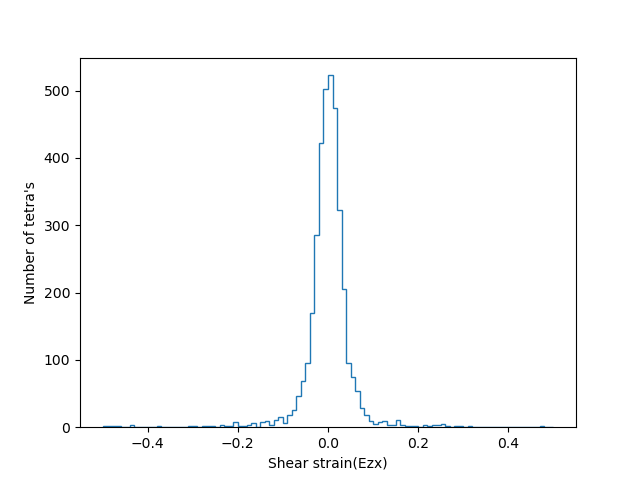

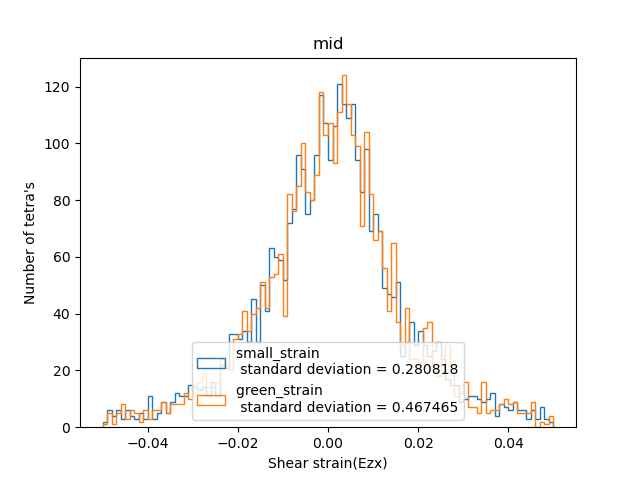

In [14]:
plt.figure()
sd_ss_fin = statistics.pstdev(sszx_fin)
sd_gs_fin = statistics.pstdev(gszx_fin)
#plt.title('fin')
#plt.hist(sszx_fin, bins=100, stacked = True, range = [-0.05, 0.05], histtype='step', fill = False)
plt.hist(gszx_fin, bins=100, stacked = True, range = [-0.5, 0.5], histtype='step', fill = False)
#plt.legend(["small_strain \n standard deviation = %f"%sd_ss_fin, "green_strain \n standard deviation = %f"%sd_gs_fin],loc = 'lower center')
plt.ylabel("Number of tetra's")
plt.xlabel("Shear strain(Ezx)")
plt.savefig("EZX_hist.png", dpi = 600)
plt.show()

plt.figure()
sd_ss_mid = statistics.pstdev(sszx_mid)
sd_gs_mid = statistics.pstdev(gszx_mid)
plt.title('mid')
plt.hist(sszx_mid, bins=100, stacked = True, range = [-0.05, 0.05], histtype='step', fill = False)
plt.hist(gszx_mid, bins=100, stacked = True, range = [-0.05, 0.05], histtype='step', fill = False)
plt.legend(["small_strain \n standard deviation = %f"%sd_ss_mid, "green_strain  \n standard deviation = %f"%sd_gs_mid], loc = 'lower center')
plt.ylabel("Number of tetra's")
plt.xlabel("Shear strain(Ezx)")
#plt.savefig("tetras_apect_2.png", dpi = 600)
plt.show()
